In [1]:
import numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt
import tqdm
import json

import importlib
import mystuff
importlib.reload(mystuff)

<module 'mystuff' from '/home/luca/projects/nttn/mystuff.py'>

In [4]:
rng = np.random.default_rng(seed=0)
NUM_RUNS = 4

model_names = ['model0', 'model6', 'model10']
ranks = mystuff.logspace_int(start=16, end=800, n=32)
results = {
    'ranks': ranks,
}

In [6]:
for model_name in model_names:
    print(f'starting {model_name}')
    model = mystuff.MnistFCNet(name=model_name, seed=0)
    model.init_model(activation=F.relu, dropout=0)
    model.init_data_loader(batch_size=64)
    model.load_from_file()

    print('running base benchmarks... ', end='')
    base_loss, base_acc = model.score()
    result = {
        'base_loss': base_loss,
        'base_acc': base_acc,
    }
    print('DONE')

    W = model.copy_weights_of_interest()

    print(f'computing random compression scores in {NUM_RUNS} runs')
    losses_per_run = []
    accs_per_run = []

    def compute_random_compression_score(rank):
        G = rng.standard_normal(size=(1000, rank))
        Y = W @ G
        Q, _ = np.linalg.qr(Y)
        B = Q.T @ W
        Utilda, s, V = np.linalg.svd(B, full_matrices=False)
        U = Q @ Utilda @ np.diag(s)
        model.exchange_woi_with_factorization(U, V)
        return model.score()

    for run in range(NUM_RUNS):
        print(f'starting run {run+1}/{NUM_RUNS}...')
        losses_per_run.append([])
        accs_per_run.append([])
        for loss, acc in tqdm.tqdm(map(compute_random_compression_score, ranks), total=len(ranks)):
            losses_per_run[run].append(loss)
            accs_per_run[run].append(acc)

    result['losses_per_run'] = losses_per_run
    result['accs_per_run'] = accs_per_run
    results[model_name] = result
    print('DONE', end='\n\n')

json.dump(results, open('random_compression_results.json', 'w'))

starting model0
running base benchmarks... DONE
computing random compression scores in 4 runs
starting run 1/4...


100%|██████████| 32/32 [02:06<00:00,  3.96s/it]


starting run 2/4...


100%|██████████| 32/32 [01:56<00:00,  3.64s/it]


starting run 3/4...


100%|██████████| 32/32 [02:21<00:00,  4.42s/it]


starting run 4/4...


100%|██████████| 32/32 [01:47<00:00,  3.36s/it]


DONE

starting model6
running base benchmarks... DONE
computing random compression scores in 4 runs
starting run 1/4...


100%|██████████| 32/32 [01:57<00:00,  3.67s/it]


starting run 2/4...


100%|██████████| 32/32 [02:03<00:00,  3.85s/it]


starting run 3/4...


100%|██████████| 32/32 [01:44<00:00,  3.26s/it]


starting run 4/4...


100%|██████████| 32/32 [01:46<00:00,  3.33s/it]


DONE

starting model10
running base benchmarks... DONE
computing random compression scores in 4 runs
starting run 1/4...


100%|██████████| 32/32 [01:43<00:00,  3.24s/it]


starting run 2/4...


100%|██████████| 32/32 [01:44<00:00,  3.26s/it]


starting run 3/4...


100%|██████████| 32/32 [01:47<00:00,  3.35s/it]


starting run 4/4...


100%|██████████| 32/32 [05:22<00:00, 10.08s/it]

DONE



In [ ]:
results = json.load(open('random_compression_results.json', 'r'))

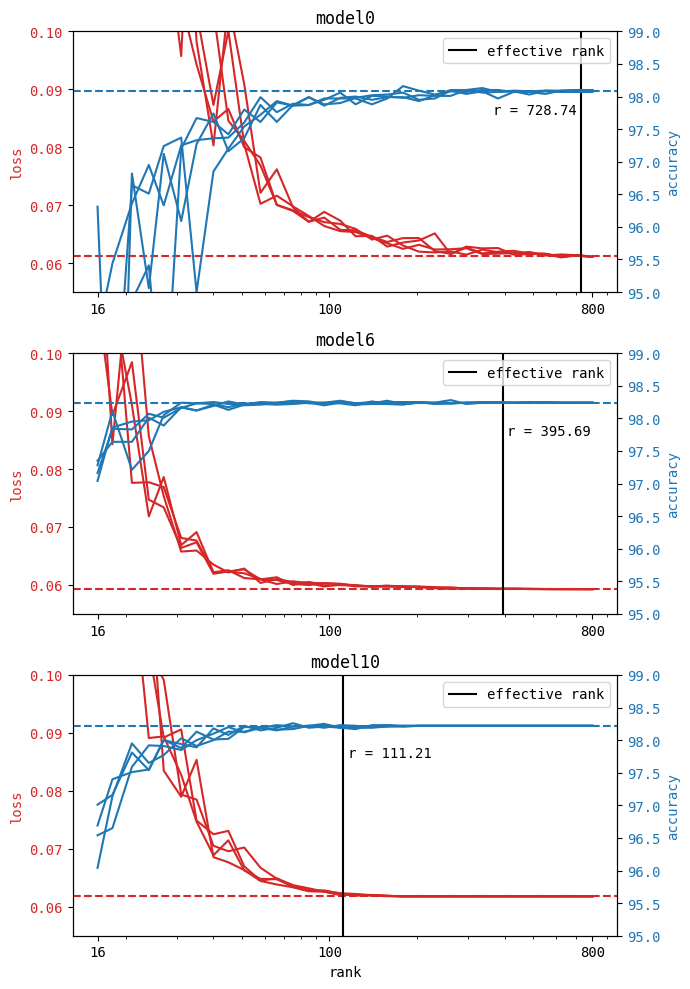

In [40]:
ranks = np.tile(np.array(results['ranks']), (NUM_RUNS, 1)).T

effective_ranks = [728.74, 395.69, 111.21]

plt.rcParams["font.family"] = "monospace"
fig, ax = plt.subplots(3, 1)

for i, model_name in enumerate(model_names):
    base_acc = np.array(results[model_name]['base_acc'])
    accs_per_run = np.array(results[model_name]['accs_per_run']).T
    base_loss = np.array(results[model_name]['base_loss'])
    losses_per_run = np.array(results[model_name]['losses_per_run']).T

    ax[i].set_title(model_name)

    if i == len(ax) - 1: ax[i].set_xlabel('rank')
    ax[i].set_xscale('log')
    ax[i].set_xticks([ranks[0,0], 100, ranks[-1,0]])
    ax[i].set_xticklabels([ranks[0,0], 100, ranks[-1,0]])

    color = 'tab:red'
    ax[i].set_ylabel('loss', color=color)
    ax[i].set_ylim((0.055, 0.1))
    ax[i].plot(ranks, losses_per_run, color=color)
    ax[i].tick_params(axis='y', labelcolor=color)
    ax[i].axhline(base_loss, color=color, ls='--')

    ax[i].axvline(effective_ranks[i], color='black', label='effective rank')
    effrk_ha = ['right', 'left', 'left']
    effrk_xoff = [-20, 10, 5]
    ax[i].text(effective_ranks[i] + effrk_xoff[i], 0.7, f'r = {effective_ranks[i]}', 
               color='black', transform=ax[i].get_xaxis_transform(), ha=effrk_ha[i], va='center')
    ax[i].legend(loc='upper right')

    axtwin = ax[i].twinx()
    color = 'tab:blue'
    axtwin.set_ylabel('accuracy', color=color)
    axtwin.set_ylim((95, 99))
    axtwin.plot(ranks, accs_per_run, color=color)
    axtwin.tick_params(axis='y', labelcolor=color)
    axtwin.axhline(base_acc, color=color, ls='--')
    

fig.set_size_inches(7, 10)
fig.tight_layout()
plt.savefig('random_compression.png')
plt.show()